# Geospatial Elasticsearch Geo Aggregations with Python

In [1]:
%matplotlib inline

In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyproj
import shapely.geometry
import geopandas as gpd

from pprint import pprint
from dotenv import load_dotenv
from elasticsearch import Elasticsearch

load_dotenv(".env");

In [3]:
#filepath = "/home/hadoop/sgds/data/naturalearth/" \
#           "ne_10m_admin_0_countries.shp"
filepath = "/home/hadoop/sgds/data/naturalearth/" \
           "ne_110m_admin_0_countries.shp"

gdf_ne = gpd.read_file(filepath)

In [6]:
es = Elasticsearch(hosts=['http://{}:{}@{}:{}'.format(
    os.environ["ES_USERNAME"],
    os.environ["ES_PASSWORD"],
    os.environ["ES_HOST"],
    os.environ["ES_PORT"],
)])

In [7]:
es.count(index='gdelt_custom_2020')

{'count': 24330238,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}

# Geohash Grid Aggregation

- [Geohash Grid Aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geohashgrid-aggregation.html)

In [6]:
%%time
result = es.search(index='gdelt_custom_2020', body={
    #"size": 10000,
    "size": 0,
    "query": {
        "bool": {
            "must": [],
            "must_not": []
        }
    },
    "aggs": {
        "scene-grid": {
            "geohash_grid": {
                "field": "location",
                "precision": 2
            }
        }
    }
})

print('total', result['hits']['total']['value'])

total 10000
CPU times: user 0 ns, sys: 3.8 ms, total: 3.8 ms
Wall time: 49.5 ms


In [7]:
df = pd.DataFrame(result['aggregations']['scene-grid']['buckets'])
df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   key        293 non-null    object
 1   doc_count  293 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 19.3 KB


,key,doc_count
0,dr,6483
1,sv,5964
2,dq,4413
3,gc,4072
4,dp,3603


In [8]:
import geohash
import shapely.geometry

In [9]:
%%time
def get_geohash_geometry(gh_code):
    coords = geohash.bbox(gh_code)
    # (minx, miny, maxx, maxy)
    extent = [coords['w'], coords['s'], 
              coords['e'], coords['n']]
    return shapely.geometry.box(*extent)

df['geom'] = df['key'].apply(get_geohash_geometry)

CPU times: user 6.88 ms, sys: 3.54 ms, total: 10.4 ms
Wall time: 7.64 ms


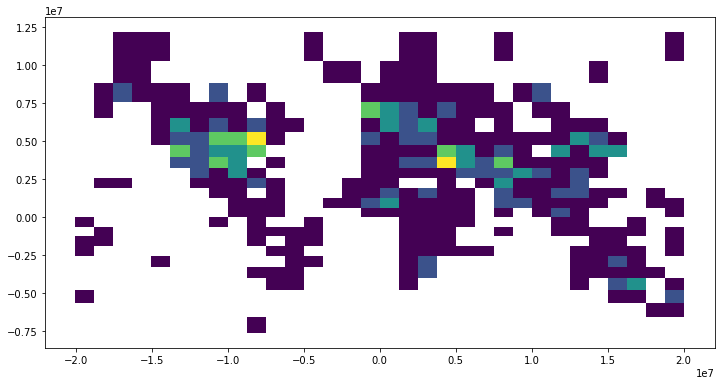

In [10]:
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')

mask = gdf.geom.apply(lambda g: g.centroid.y > -80)

gdf[mask].to_crs(epsg=3857).plot(figsize=(12, 12), 
                                 column='doc_count', 
                                 cmap='viridis', 
                                 scheme='naturalbreaks', k=5);

# GeoTile Grid Aggregation

> A multi-bucket aggregation that works on `geo_point` fields and groups points into buckets that represent cells in a grid. The resulting grid can be sparse and only contains cells that have matching data. Each cell corresponds to a [map tile](https://en.wikipedia.org/wiki/Tiled_web_map) as used by many online map sites. Each cell is labeled using a "{zoom}/{x}/{y}" format, where zoom is equal to the user-specified precision.

- [GeoTile Grid Aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geotilegrid-aggregation.html)
- OpenStreetMap Wiki - [Slippy Map](https://wiki.openstreetmap.org/wiki/Slippy_Map)
- OpenStreetMap Wiki - [Slippy map tilenames](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames)
- Github - [mapbox/mercantile](https://github.com/mapbox/mercantile)

In [56]:
%%time
EXTENT = [-126.6,23.1,-64.4,49.3]

result = es.search(index='gdelt_custom_2020', body={
    #"size": 10000,
    "size": 0,
    "query": {
        "bool": {
            "must": [],
            "must_not": [],
            #"filter" : {
            #    "geo_bounding_box" : {
            #        "location" : {
            #            "top_left" : [EXTENT[0], EXTENT[3]],
            #            "bottom_right" : [EXTENT[2], EXTENT[1]]
            #        }
            #    }
            #}
        }
    },
    "aggs": {
        "scene-grid": {
            "geotile_grid": {
                "field": "location",
                "precision": 6
            }
        }
    }
})

print('total', result['hits']['total']['value'])

total 10000
CPU times: user 8.1 ms, sys: 0 ns, total: 8.1 ms
Wall time: 208 ms


In [57]:
df = pd.DataFrame(result['aggregations']['scene-grid']['buckets'])
df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   key        512 non-null    object
 1   doc_count  512 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 36.1 KB


,key,doc_count
0,6/18/24,5709
1,6/39/25,3796
2,6/41/25,3118
3,6/18/23,2707
4,6/19/23,2365


In [58]:
df[['z', 'x', 'y']] = df['key'].apply(
    lambda k: pd.Series([int(k) for k in k.split('/')], 
                        index=['z', 'x', 'y']))

In [59]:
def xyz_tile_to_bbox(x, y, z):
    n = 2**z
    lon_deg0 = x / n * 360.0 - 180.0
    lat_rad0 = np.arctan(np.sinh(np.pi * (1 - 2 * y / n)))
    lat_deg0 = lat_rad0 * 180.0 / np.pi
    lon_deg1 = (x + 1) / n * 360.0 - 180.0
    lat_rad1 = np.arctan(np.sinh(np.pi * (1 - 2 * (y + 1) / n)))
    lat_deg1 = lat_rad1 * 180.0 / np.pi
    
    # [W, S, E, N]
    extent = [lon_deg0, lat_deg1, lon_deg1, lat_deg0]
    return shapely.geometry.box(*extent)

In [60]:
df['geom'] = df.apply(
    lambda row: xyz_tile_to_bbox(row['x'], row['y'], row['z']), axis=1)

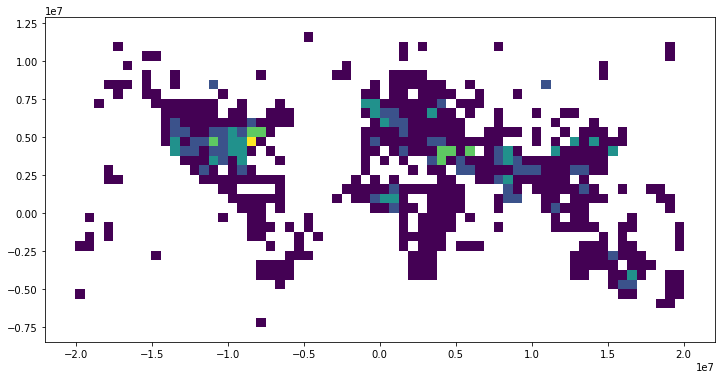

In [61]:
gdf = gpd.GeoDataFrame(df, geometry='geom', crs='epsg:4326')

mask = gdf.geom.apply(lambda g: g.centroid.y > -80)

gdf[mask].to_crs(epsg=3857).plot(figsize=(12, 12), 
                                 column='doc_count', 
                                 cmap='viridis', 
                                 scheme='naturalbreaks', k=5);

# Geo Bounds Aggregation

> A metric aggregation that computes the bounding box containing all geo values for a field.

- [Geo Bounds Aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-metrics-geobounds-aggregation.html)

In [73]:
%%time
result = es.search(index='gdelt_custom_2020', body={
    #"size": 10000,
    "size": 0,
    "aggs": {
        "viewport": {
            "geo_bounds": {
                "field": "location",    
                "wrap_longitude": True  
            }
        }
    }
})

print('total', result['hits']['total']['value'])

total 10000
CPU times: user 3.82 ms, sys: 396 µs, total: 4.21 ms
Wall time: 359 ms


In [76]:
pprint(result['aggregations'])

{'viewport': {'bounds': {'bottom_right': {'lat': -85.62210003845394,
                                          'lon': 179.33299999684095},
                         'top_left': {'lat': 71.9999999832362,
                                      'lon': -176.5330000128597}}}}


# Geo Centroid Aggregation

> A metric aggregation that computes the weighted [centroid](https://en.wikipedia.org/wiki/Centroid) from all coordinate values for a [Geo-point datatype](https://www.elastic.co/guide/en/elasticsearch/reference/6.8/geo-point.html) field.

- [Geo Centroid Aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/6.8/search-aggregations-metrics-geocentroid-aggregation.html)

In [68]:
%%time
result = es.search(index='gdelt_custom_2020', body={
    #"size": 10000,
    "size": 0,
    "aggs": {
        "centroid": {
            "geo_centroid": {
                "field": "location",    
            }
        }
    }
})

print('total', result['hits']['total']['value'])

total 10000
CPU times: user 4.18 ms, sys: 0 ns, total: 4.18 ms
Wall time: 216 ms


In [71]:
pprint(result['aggregations'])

{'centroid': {'count': 97148,
              'location': {'lat': 30.46608442130391,
                           'lon': 0.35541025303929935}}}


# Geo Distance Aggregation

> A multi-bucket aggregation that works on `geo_point` fields and conceptually works very similar to the [range](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-range-aggregation.html) aggregation. The user can define a point of origin and a set of distance range buckets. The aggregation evaluate the distance of each document value from the origin point and determines the buckets it belongs to based on the ranges 

- [Geo Distance Aggregation](https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geodistance-aggregation.html)

In [84]:
%%time
lat, lon = 48.864716, 2.349014

result = es.search(index='gdelt_custom_2020', body={
    #"size": 10000,
    "size": 0,
    "aggs": {
        "rings": {
            "geo_distance": {
                "field": "location",    
                "origin": {"lat": lat, "lon": lon},
                "unit": "km",
                "ranges": [
                    {"to":   1000},
                    {"from": 1000, "to": 2000},
                    {"from": 2000}
                ]
            }
        }
    }
})

print('total', result['hits']['total']['value'])

total 10000
CPU times: user 6.03 ms, sys: 204 µs, total: 6.24 ms
Wall time: 27.5 ms


In [85]:
pprint(result['aggregations'])

{'rings': {'buckets': [{'doc_count': 7492,
                        'from': 0.0,
                        'key': '*-1000.0',
                        'to': 1000.0},
                       {'doc_count': 3015,
                        'from': 1000.0,
                        'key': '1000.0-2000.0',
                        'to': 2000.0},
                       {'doc_count': 86641,
                        'from': 2000.0,
                        'key': '2000.0-*'}]}}
